In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random
import os
%matplotlib inline

# Note! All images are loaded as BGR and not RGBs, and all functions that use that colorspace assume BGR

class CameraCalibration():
    def __init__(self):
        self.mtx = None
        self.dist = None
        
    def calibrate(self, path, inside_corners=(9,6)):
        imagefiles = glob.glob(os.path.join(path, '*.jpg')) # All images in the camera calibration path 
        # Initialise image and object point arrays
        objpoints = [] # 3D points in real space
        imgpoints = [] # 2D points in image plane
        
        # Prepare object points (0,0,0), (0,1,0), (9,6,0) - all z's should be zero
        objp = np.zeros((inside_corners[0]*inside_corners[1],3), np.float32)
        objp[:,:2] = np.mgrid[0:inside_corners[0], 0:inside_corners[1]].T.reshape(-1,2) 
        
        for filename in imagefiles:
            image = cv2.imread(filename)
            
            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, inside_corners, None)
            
            # If found, draw corners
            if ret == True:
                # Add object points
                objpoints.append(objp)
                # Add image points
                imgpoints.append(corners)   
                
        
        _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
        print('Calibration finished')
        
    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        
class BinaryFilter():
    def __init__(self, sobel_thresh=(25, 100), s_thresh = 160, b_thresh = 45, gb_kernel=(3,3)):
        self.sobel_thresh = sobel_thresh # Threshold for Sobel derivative
        self.s_thresh = s_thresh # Threshold for s channel in HLS transform
        self.b_thresh = b_thresh # Threshold for b channel in LAB transform
        self.gb_kernel = gb_kernel # kernel size for Guassian blurring

    def get_binary_image(self, img):
        blur = cv2.GaussianBlur(img, self.gb_kernel, 0)
        
        r_channel = blur[:,:,2]
        r_thresh = (220, 240)
        r_binary = np.zeros_like(r_channel)
        r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
        
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls = cv2.cvtColor(blur, cv2.COLOR_BGR2HLS)
        s_channel = hls[:,:,2]
        
        # Grayscale image
        # NOTE: we already saw that standard grayscaling lost color information for the lane lines
        # Explore gradients in other colors spaces / color channels to see what might work better
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Take sobel in x 
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))  
        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= self.sobel_thresh[0]) & (scaled_sobel <= self.sobel_thresh[1])] = 1

        # Threshold s color channel
        s_thresh_min = self.s_thresh
        s_thresh_max = 200
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        
        # Combine the binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1) | (r_binary == 1)] = 1
        
        return combined_binary

class PerspectiveTransform():
    def __init__(self, src=None, dst=None):
        self.src = np.float32(
                [[580, 450],
                 [45, 720],
                 [1235, 720],
                 [694, 450]])
                 
        self.dst = np.float32(
                [[150, 0],
                 [150, 720],
                 [1130, 720],
                 [1130, 0]])
                 
        self.M = []
        self.Minv = []
                 
    def get_perspective_transform(self):
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def apply_perspective_transform(self,img, inverse=False):
        imshape = img.shape
        if not self.M:
            self.get_perspective_transform()
        # Warp onto birds-eye-view
        # Previous region-of-interest mask's function is absorbed by the warp
        if inverse:
            M = self.Minv
        else:
            M = self.M
        return cv2.warpPerspective(img, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)


# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, nwindows = 10, windowmargin = 80, minpix = 50):
        # was the line detected in the last iteration?
        self.detected = True  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([0,0,0], dtype='float') 
        #polynomial coefficients for the most recent fit
        self.previous_fit =  np.array([0,0,0], dtype='float') 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []
        # Choose the number of sliding windows
        self.nwindows = nwindows
        # Set the width of the windows +/- margin
        self.windowmargin = windowmargin
        # Set minimum number of pixels found to recenter window
        self.minpix = minpix
        self.x = []
        self.y = []
        self.alpha = 0.7
        self.framecount = 0
        self.base = 0
        
        
    def split_image(self, img, isLeft=True, display=True):
        self.isLeft = isLeft
        # First function to be called, seperates left and right image to isolate the left and right lanes
        midpoint = np.int(img.shape[1]/2)
        if isLeft:
            self.img = img[:, 0:midpoint]
        else:
            self.img = img[:, midpoint:img.shape[1]]
        self.out_img = self.img
        self.display = display

    def sliding_window_histogram(self, nonzeroy, nonzerox):
        img = self.img
        histogram = np.sum(img[np.int(img.shape[0]//2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
        base = np.argmax(histogram)
        # Set height of windows
        window_height = np.int(img.shape[0]/self.nwindows)
        # Current positions to be updated for each window
        if self.framecount > 0:
            current = np.int(base * self.alpha + (1-self.alpha)*self.base)
        else:
            current = base
        
        self.base = base
        # Set the width of the windows +/- margin
        margin = self.windowmargin
        # Set minimum number of pixels found to recenter window
        minpix = self.minpix
        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []
        
        mean_x = nonzerox.mean()
        std_x = nonzerox.std()
    
        # remove outlier points 
        nonzerox = nonzerox[np.abs(nonzerox-mean_x) < 1.4*std_x]
        nonzeroy = nonzeroy[np.abs(nonzerox-mean_x) < 1.4*std_x]

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_x_low = current - margin
            win_x_high = current + margin
            # Draw the windows on the visualization image
            if self.display:
                cv2.rectangle(out_img,(win_x_low,win_y_low),(win_x_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                current = np.int(np.mean(nonzerox[good_inds]))
        self.out_img = out_img
        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)
        
        # Extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 


        # Fit a second order polynomial to each
        fit = np.polyfit(y, x, 2)
        
        self.previous_fit = self.current_fit
        self.current_fit = fit
        self.detected = True
        self.allx.append(x)
        self.ally.append(y)
        self.x = x
        self.y = y
        
        return fit, x, y
    
    def plot_search_windows(self, displayPlot=True):
        img = self.img
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        fitx = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]
        
        if self.isLeft:
            clr = [255, 0, 0]
        else:
            clr = [0, 0, 255]
        
        out_img = self.out_img
        out_img[self.y, self.x] = clr
        
        if displayPlot:
            plt.imshow(out_img)
            plt.plot(fitx, ploty, color='yellow')
        if not self.isLeft:
            fitx = fitx + np.int(img.shape[1])
        return out_img, fitx, ploty


    def search_known_window(self, nonzeroy, nonzerox):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "img")
        # It's now much easier to find line pixels! 

        
        margin = self.windowmargin
        
        fit = self.current_fit
        
        lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] - margin)) & (nonzerox < (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] + margin))) 

        # Again, extract line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        # Fit a second order polynomial to each
        fit = np.polyfit(y, x, 2)
        
        self.previous_fit = self.current_fit
        self.current_fit = fit
        self.detected = True
        self.allx.append(x)
        self.ally.append(y)
        self.x = x
        self.y = y 
        
        return fit, x, y
        
    def lanedetection(self):
        nonzero = self.img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        #if (not self.detected) and (self.framecount > 10):
        #    nonzerox = self.allx[-1]
        #    nonzeroy = self.ally[-1]
        
        fit, x, y = self.sliding_window_histogram(nonzeroy, nonzerox)
        fit0 = fit[0]*self.alpha + np.array(self.previous_fit[0])*(1-self.alpha)
        fit1 = fit[1]*self.alpha + np.array(self.previous_fit[1])*(1-self.alpha)
        fit2 = fit[2]*self.alpha + np.array(self.previous_fit[2])*(1-self.alpha)
        
        if self.framecount > 0:
            fit = [fit0, fit1, fit2]        
        
        self.current_fit = fit
        
        self.diffs = np.array(self.current_fit) - np.array(self.previous_fit)
        
        if np.linalg.norm(np.array(self.diffs)) > (0.3 * np.linalg.norm(np.array(self.previous_fit))) :
            self.detected = False
        
        self.framecount += 1
        # Choose between histogram search or known search
        
        #fit, x, y = self.sliding_window_histogram(nonzeroy, nonzerox)
        #polyFit = np.array(self.recentXfitted[-self.smoothLimiter:]).mean(axis=0) * 0.2 + polyFit * 0.8
        return fit, x, y
        
    def get_curvature(self):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = self.img.shape[0]
        curverad = ((1 + (2*self.current_fit[0]*y_eval + self.current_fit[1])**2)**1.5) / np.absolute(2*self.current_fit[0])

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(self.y*ym_per_pix, self.x*xm_per_pix, 2)
        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        # Now our radius of curvature is in meters
        self.radius_of_curvature = curverad
        return curverad
    
class LaneTool():
    def __init__(self, left_curverad=0, right_curverad=0, detected=False):
        self.img = None
        self.left_curverad = left_curverad
        self.right_curverad = right_curverad
        self.detected = detected

    
    def join_left_right(self, left_img, right_img, fitx_left, fitx_right, ploty):
        self.left_fitx = fitx_left
        self.right_fitx = fitx_right
        self.ploty = ploty
        self.img = np.concatenate((left_img, right_img), axis=1)
        
    def set_warp_factor(self, Minv):
        self.Minv = Minv
        
    def draw_lane(self, original_img, binary_warped_img, display=True ):
        # Original undistorted image combines with the binary warped image
        image = original_img
        warp_zero = np.zeros_like(binary_warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)

        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        middle = (self.left_fitx[-1] + self.right_fitx[-1])//2
        veh_pos = image.shape[1]//2
        dx = (veh_pos - middle)*xm_per_pix # Positive if on right, Negative on left
        cv2.putText(result,'Left radius of curvature  = %.2f m'%(self.left_curverad),(50,50), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(result,'Right radius of curvature = %.2f m'%(self.right_curverad),(50,80), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(dx), 'left' if dx < 0 else 'right'),(50,110), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)
        is_tracking = self.detected
        cv2.putText(result,'Tracking Locked' if is_tracking else 'Tracking Lost',(50,140), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,0) if is_tracking else (255,0,0), 3,cv2.LINE_AA)
        #result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        if display:
            plt.imshow(result)
        return result

In [2]:
cc = CameraCalibration()
cc.calibrate(path='camera_cal/')
undistort = cc.undistort  # rename function for easy use.

Calibration finished


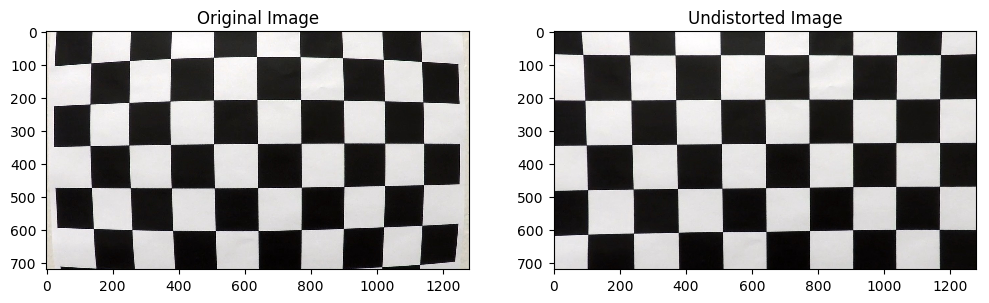

In [3]:
img = plt.imread('camera_cal/calibration1.jpg')
undistorted = undistort(img)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(undistorted)
plt.title('Undistorted Image')
plt.savefig('chessboard_undistortion.jpg')
plt.show()

In [4]:
test_img_paths = sorted(glob.glob('test_images/*.jpg'))

for test_img_path in test_img_paths:
    img = plt.imread(test_img_path)
    undist = undistort(img)
    basename = os.path.basename(test_img_path)
    plt.imsave(os.path.join('output_images', basename.split('.')[0]+'_undist.jpg'), undist)

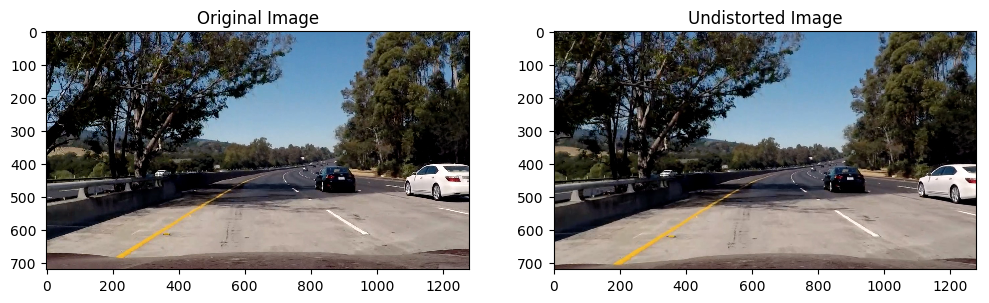

In [5]:

img = plt.imread('test_images/test5.jpg')
img_undist = plt.imread('output_images/test5_undist.jpg')
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(img_undist)
plt.title('Undistorted Image')
plt.savefig('undistortion_example.jpg')
plt.show()

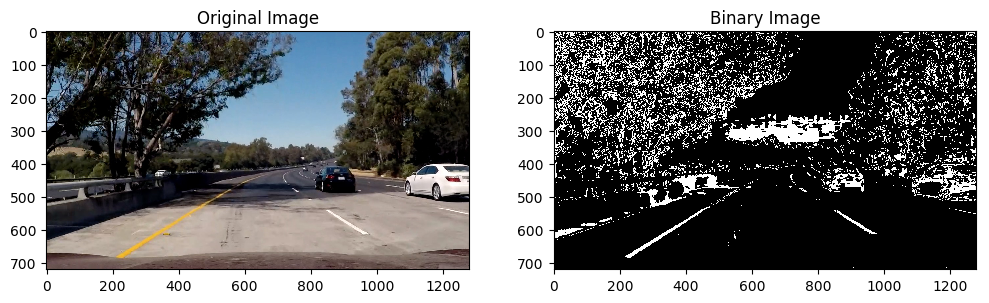

In [6]:
img = plt.imread('test_images/test5.jpg')
llf = BinaryFilter()
binary = llf.get_binary_image(img)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(binary, 'gray')
plt.title('Binary Image')
plt.savefig('binary_example.jpg')
plt.show()

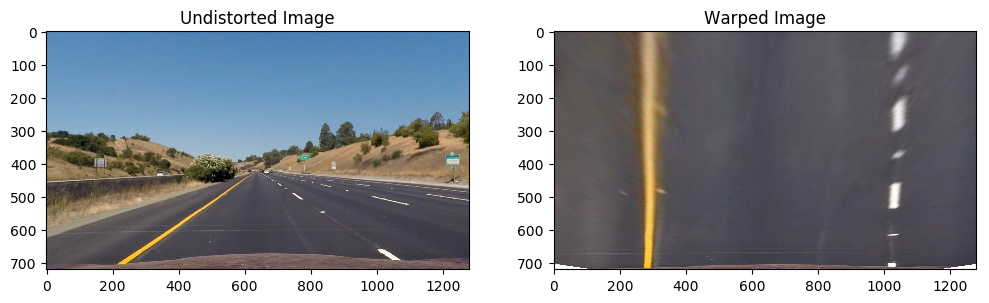

In [7]:
img = plt.imread('output_images/straight_lines1_undist.jpg')
wp = PerspectiveTransform()
warped = wp.apply_perspective_transform(img)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Undistorted Image')
plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.title('Warped Image')
plt.savefig('warp_example.jpg')
plt.show()

In [ ]:
img = plt.imread('test_images/test2.jpg')
leftline = Line()
rightline = Line()
cc = CameraCalibration()
cc.calibrate(path='camera_cal/')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:201: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 21971 but corresponding boolean dimension is 20045
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:201: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 17150 but corresponding boolean dimension is 14887


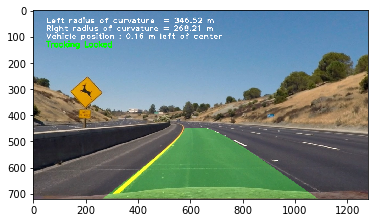

In [9]:

def image_pipeline(img):
    undist_img = cc.undistort(img)
    # Binary filter
    bf = BinaryFilter()
    binary = bf.get_binary_image(img)

    # Perspective Warp
    wp = PerspectiveTransform()
    warped = wp.apply_perspective_transform(binary)

    leftline.split_image(warped,isLeft=True, display=True)
    rightline.split_image(warped,isLeft=False, display=True)
    leftfit, leftx, lefty = leftline.lanedetection()
    rightfit, rightx, righty = rightline.lanedetection()

    outleft, fitx_left, ploty = leftline.plot_search_windows(displayPlot=False)
    outright, fitx_right, ploty = rightline.plot_search_windows(displayPlot=False)

    left_curvature = leftline.get_curvature()
    right_curvature = rightline.get_curvature()
    
    Minv = wp.Minv
    detected = (leftline.detected and rightline.detected)

    lt = LaneTool(left_curvature, right_curvature, detected)
    lt.set_warp_factor(Minv)
    lt.join_left_right(left_img=outleft, right_img=outright, fitx_left=fitx_left, fitx_right=fitx_right, ploty=ploty)

    final_image = lt.draw_lane(undist_img, warped, display=False)
    return final_image

final_image = image_pipeline(img)
plt.imshow(final_image)

In [14]:
from moviepy.editor import VideoFileClip

output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [02:55<00:00,  6.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 6min 4s, sys: 12.3 s, total: 6min 17s
Wall time: 2min 56s


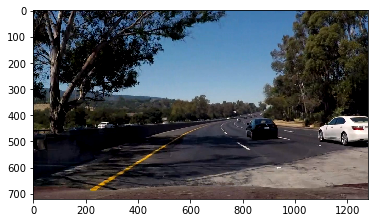

In [19]:
img = clip1.get_frame(41.5)
plt.imshow(img)
plt.imsave('testimage',img)

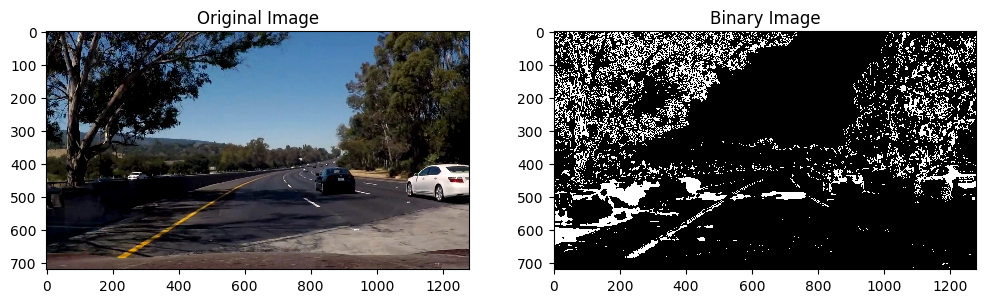

In [23]:
llf = BinaryFilter()
binary = llf.get_binary_image(img)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(binary, 'gray')
plt.title('Binary Image')
plt.savefig('binary_example.jpg')
plt.show()

160


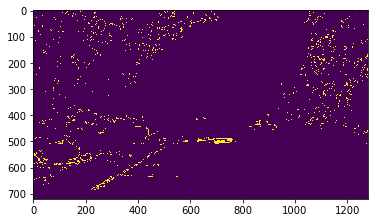

In [60]:
bf = BinaryFilter()
blur = cv2.GaussianBlur(img, bf.gb_kernel, 0)

r_channel = blur[:,:,2]
r_thresh = (170, 220)
r_binary = np.zeros_like(r_channel)
r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(blur, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Take sobel in x 
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))  
# Threshold x gradient
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= bf.sobel_thresh[0]) & (scaled_sobel <= bf.sobel_thresh[1])] = 1

print(bf.s_thresh)
# Threshold s color channel
s_thresh_min = 170
s_thresh_max = 210
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Combine the binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1) | (r_binary == 1)] = 1

plt.imshow(s_binary)

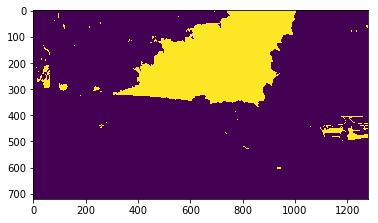